In [81]:
%pip install pandas numpy matplotlib scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, math, random, time


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Provide sensor data recording to run the processing/analysis on

In [82]:
import config
from importlib import reload
reload(config)
from config import *

### Cut off debug data from flashing if there's any left

In [83]:
HEADERS = "time,gyro.x,gyro.y,gyro.z,accel.x,accel.y,accel.z"
lines = []
cutting = False
with open(SENSOR_DATA, 'r') as file:
    found_start = False
    for (i, line) in enumerate(file.readlines()):
        if not found_start and HEADERS in line:
            if i == 0:
                break
            found_start = True
            cutting = True
        if found_start:
            lines.append(line)
if cutting:
    with open(SENSOR_DATA, 'w') as file:
        file.writelines(lines[:-1])

### Run the sensor processing code

In [84]:
result = os.system(f'RUST_LOG=debug cargo run --release -- {SENSOR_DATA}')
if result != 0:
    raise Exception('Failed to compile sensor data')

    Finished `release` profile [optimized] target(s) in 0.04s
     Running `target/release/test-processing recordings/bling2_walk.csv`
[2024-12-14T13:17:16Z DEBUG lib_processing::step_detection] Step started: 48118095872
[2024-12-14T13:17:16Z DEBUG lib_processing::step_detection] Peak passed: 48559603712
[2024-12-14T13:17:16Z DEBUG lib_processing::step_detection] Minimum velocity sum: 0.9330671
[2024-12-14T13:17:16Z DEBUG lib_processing::step_detection] Step ended: 48716828672
[2024-12-14T13:17:16Z WARN  lib_processing::step_detection] Reset position and velocity after last step: 48735162368
[2024-12-14T13:17:16Z DEBUG lib_processing::step_detection] Step started: 49381765120
[2024-12-14T13:17:16Z DEBUG lib_processing::step_detection] Peak passed: 49778774016
[2024-12-14T13:17:16Z DEBUG lib_processing::step_detection] Minimum velocity sum: -0.3877219
[2024-12-14T13:17:16Z DEBUG lib_processing::step_detection] Step ended: 49963520000
[2024-12-14T13:17:16Z WARN  lib_processing::step_dete

### Load sensor data

In [85]:
data = pd.read_csv(SENSOR_DATA)
# Convert ESP32 system time to local time so the graphs make more sense.
now = time.time()
data['t'] = pd.to_datetime((data['time'] / 1_000_000_000.0) + now, unit='s')
data.set_index(data['t'], inplace=True)
data.drop(columns=['t'], inplace=True)
data

,time,gyro.x,gyro.y,gyro.z,accel.x,accel.y,accel.z
t,,,,,,,
2024-12-14 13:18:04.222481966,47505801000,-1.072739,0.974299,-0.566168,-0.957681,4.161122,11.166556
2024-12-14 13:18:04.231636047,47514955000,-1.139253,0.903528,-0.314479,-2.437297,4.242526,10.386047
2024-12-14 13:18:04.241908073,47525227000,-1.223327,0.840738,-0.076624,-2.236184,4.419696,10.587160
2024-12-14 13:18:04.250945091,47534264000,-1.299952,0.807215,0.063854,-0.837971,4.256891,10.896012
2024-12-14 13:18:04.259953021,47543272000,-1.364869,0.829032,0.039376,0.435745,3.727772,11.118672
...,...,...,...,...,...,...,...
2024-12-14 13:18:19.173695087,62457014000,-0.910977,0.287873,-0.166551,-1.431733,-1.383849,10.565612
2024-12-14 13:18:19.182724953,62466044000,-0.924812,0.296919,-0.172405,-1.276109,-1.340753,10.510546
2024-12-14 13:18:19.191716909,62475036000,-0.939711,0.307561,-0.175597,-1.158794,-1.316811,10.381259


### Load algorithm debug data

In [86]:
algo = pd.read_csv(ALGORITHM_DATA)
# Convert ESP32 system time to local time so the graphs make more sense.
algo['t'] = pd.to_datetime((algo['time'] / 1_000_000_000.0) + now, unit='s')
algo.set_index(algo['t'], inplace=True)
algo.drop(columns=['t'], inplace=True)
algo.head()

,time,orientation.w,orientation.x,orientation.y,orientation.z,velocity.x,velocity.y,velocity.z,position.x,position.y,...,world_acc.y,world_acc.z,gyro_orientation.w,gyro_orientation.x,gyro_orientation.y,gyro_orientation.z,accel_orientation.w,accel_orientation.x,accel_orientation.y,accel_orientation.z
t,,,,,,,,,,,,,,,,,,,,,
2024-12-14 13:18:04.222482204,47505801216,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2024-12-14 13:18:04.231636763,47514955776,0.999980,-0.003247,0.005143,-0.001631,-0.021207,0.039527,0.005273,-0.000194,0.000362,...,4.317726,0.576047,0.999977,-0.005215,0.004136,-0.001439,0.975653,0.191585,0.104756,-0.020571
2024-12-14 13:18:04.241909504,47525228544,0.999916,-0.007477,0.010320,-0.002176,-0.041735,0.086649,0.013049,-0.000623,0.001252,...,4.587064,0.756868,0.999896,-0.011493,0.008461,-0.001829,0.975976,0.195537,0.094229,-0.018879
2024-12-14 13:18:04.250945330,47534264320,0.999833,-0.011357,0.014196,-0.001902,-0.046370,0.127365,0.022166,-0.001042,0.002403,...,4.506076,1.009006,0.999775,-0.017356,0.012121,-0.001533,0.982082,0.185032,0.035130,-0.006619
2024-12-14 13:18:04.259952544,47543271424,0.999721,-0.015710,0.017582,-0.001633,-0.038831,0.164049,0.032678,-0.001392,0.003880,...,4.072863,1.167054,0.999597,-0.023493,0.015866,-0.001346,0.986777,0.161015,-0.018327,0.002990


## Load detected steps

In [87]:
steps = pd.read_csv(STEPS_DATA)
steps

,start,peak,finished,peak.x,peak.y,peak.z,velocity.x,velocity.y,velocity.z
0,48118095872,48716828672,48716828672,NaN,NaN,NaN,NaN,NaN,NaN
1,49381765120,49768464384,49963520000,NaN,NaN,NaN,NaN,NaN,NaN
2,50650542080,51029868544,51196100608,NaN,NaN,NaN,NaN,NaN,NaN
3,51892412416,52235001856,52448956416,NaN,NaN,NaN,NaN,NaN,NaN
4,53096411136,53485735936,53643001856,NaN,NaN,NaN,NaN,NaN,NaN
5,54291456000,54649630720,54853079040,NaN,NaN,NaN,NaN,NaN,NaN
6,55443214336,55830257664,55961182208,NaN,NaN,NaN,NaN,NaN,NaN
7,56608911360,56996241408,57145806848,NaN,NaN,NaN,NaN,NaN,NaN
8,57831227392,58166001664,58397978624,NaN,NaN,NaN,NaN,NaN,NaN
9,59054964736,59395846144,59582189568,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
# Convert ESP32 system time to local time so the graphs make more sense.
steps['start'] = pd.to_datetime((steps['start'] / 1_000_000_000.0) + now, unit='s')
steps['peak'] = pd.to_datetime((steps['peak'] / 1_000_000_000.0) + now, unit='s')
steps['finished'] = pd.to_datetime((steps['finished'] / 1_000_000_000.0) + now, unit='s')

### Preview raw sensor data

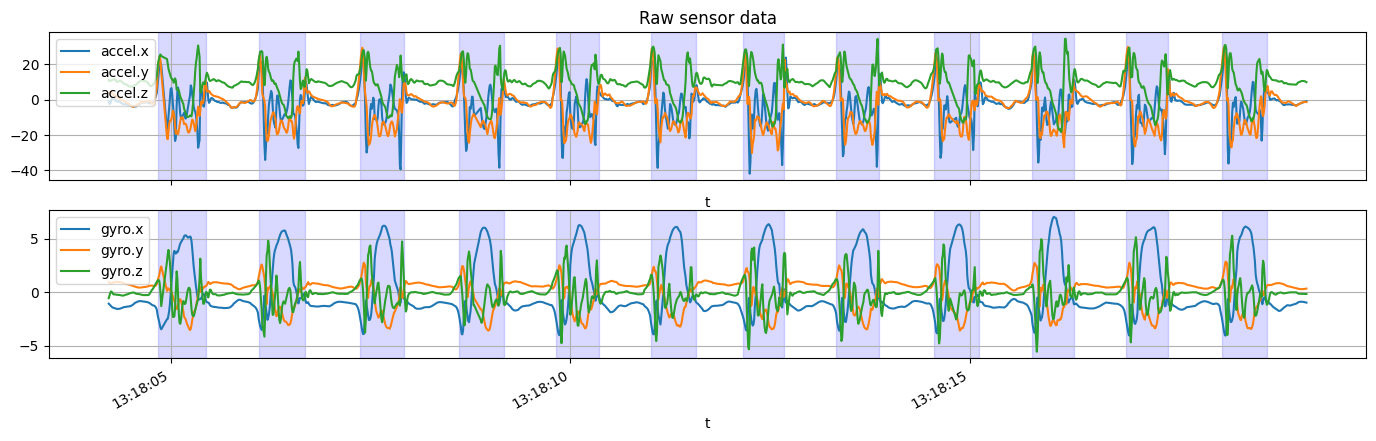

In [89]:
fig, (ax1, ax2) = plt.subplots(2, 1)

data['accel.x'].plot(ax=ax1)
data['accel.y'].plot(ax=ax1)
data['accel.z'].plot(ax=ax1)
ax1.xaxis.set_ticklabels([])
ax1.legend(loc='upper left')
ax1.grid()

data['gyro.x'].plot(ax=ax2)
data['gyro.y'].plot(ax=ax2)
data['gyro.z'].plot(ax=ax2)
ax2.legend(loc='upper left')
ax2.grid()

ax1.set_title('Raw sensor data')
fig.set_figwidth(17)

for ax in [ax1, ax2]:
    for (i, step) in steps.iterrows():
        ax.axvspan(
            step['start'],
            step['finished'],
            color='blue',
            alpha=0.15
        )

### Gravity vector length

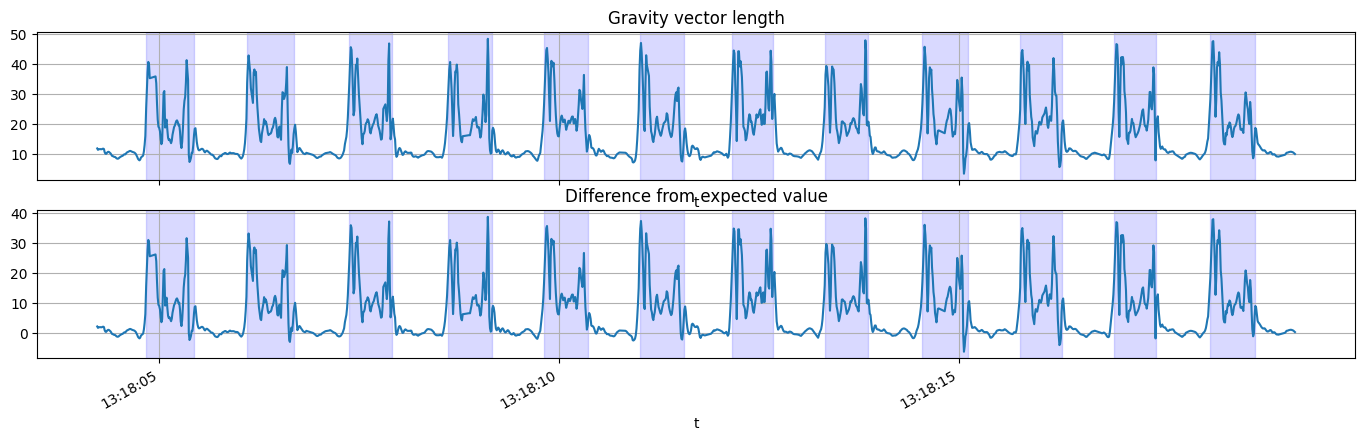

In [90]:
fig, (ax1, ax2) = plt.subplots(2, 1)

data['accel._length'] = np.sqrt(data['accel.x'] ** 2 + data['accel.y'] ** 2 + data['accel.z'] ** 2)
data['accel._length'].plot(ax=ax1)
ax1.grid()
ax1.set_title('Gravity vector length')
ax1.xaxis.set_ticklabels([])

data['gravity_delta'] = data['accel._length'] - 9.80665
data['gravity_delta'].plot(ax=ax2)
ax2.grid()
ax2.set_title('Difference from expected value')

for ax in [ax1, ax2]:
    for (i, step) in steps.iterrows():
        ax.axvspan(
            step['start'],
            step['finished'],
            color='blue',
            alpha=0.15
        )

fig.set_figwidth(17)

### Preview computed position, velocity, acceleration

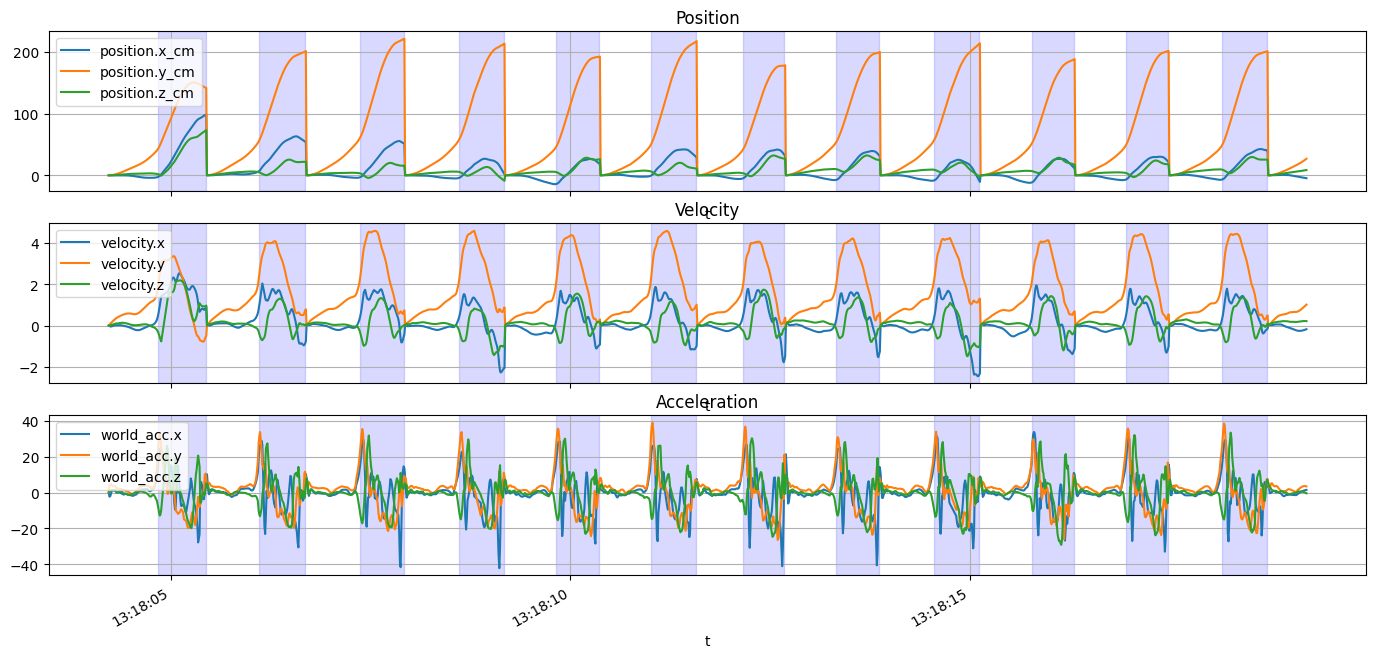

In [91]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

algo['position.x_cm'] = algo['position.x'] * 100
algo['position.y_cm'] = algo['position.y'] * 100
algo['position.z_cm'] = algo['position.z'] * 100

algo['position.x_cm'].plot(ax=ax1)
algo['position.y_cm'].plot(ax=ax1)
algo['position.z_cm'].plot(ax=ax1)
ax1.legend(loc='upper left')
ax1.grid()
ax1.set_title('Position')
ax1.xaxis.set_ticklabels([])

algo['velocity.x'].plot(ax=ax2)
algo['velocity.y'].plot(ax=ax2)
algo['velocity.z'].plot(ax=ax2)
ax2.legend(loc='upper left')
ax2.grid()
ax2.set_title('Velocity')
ax2.xaxis.set_ticklabels([])

algo['world_acc.x'].plot(ax=ax3)
algo['world_acc.y'].plot(ax=ax3)
algo['world_acc.z'].plot(ax=ax3)
ax3.legend(loc='upper left')

ax3.grid()
ax3.set_title('Acceleration')

for ax in [ax1, ax2, ax3]:
    for (i, step) in steps.iterrows():
        ax.axvspan(
            step['start'],
            step['finished'],
            color='blue',
            alpha=0.15
        )

fig.set_figwidth(17)
# fig.set_figwidth(40)
fig.set_figheight(8)

### Load Euler angles

In [92]:
angles = pd.read_csv(ANGLES_DATA)
# Convert ESP32 system time to local time so the graphs make more sense.
angles['t'] = pd.to_datetime((angles['time'] / 1_000_000_000.0) + now, unit='s')
angles.set_index(angles['t'], inplace=True)
angles.drop(columns=['t'], inplace=True)
angles.head()

,time,fusion.yaw,fusion.pitch,fusion.roll,gyro.yaw,gyro.pitch,gyro.roll,accel.yaw,accel.pitch,accel.roll,gyro.x,gyro.y,gyro.z,gyro.w
t,,,,,,,,,,,,,,
2024-12-14 13:18:04.222482204,47505801216,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
2024-12-14 13:18:04.231636763,47514955776,-0.188838,0.588752,-0.373106,-0.167422,0.473047,-0.598254,0.000000e+00,12.256749,22.219185,-0.005215,0.004136,-0.001439,0.999977
2024-12-14 13:18:04.241909504,47525228544,-0.258188,1.180744,-0.859500,-0.220798,0.967067,-1.318963,0.000000e+00,11.029486,22.658497,-0.011493,0.008461,-0.001829,0.999896
2024-12-14 13:18:04.250945330,47534264320,-0.236466,1.624201,-1.304908,-0.199821,1.385750,-1.991536,0.000000e+00,4.097292,21.339766,-0.017356,0.012121,-0.001533,0.999775
2024-12-14 13:18:04.259952544,47543271424,-0.218884,2.011703,-1.804443,-0.197012,1.814058,-2.695828,2.669884e-08,-2.127992,18.534815,-0.023493,0.015866,-0.001346,0.999597


### Compare orientations

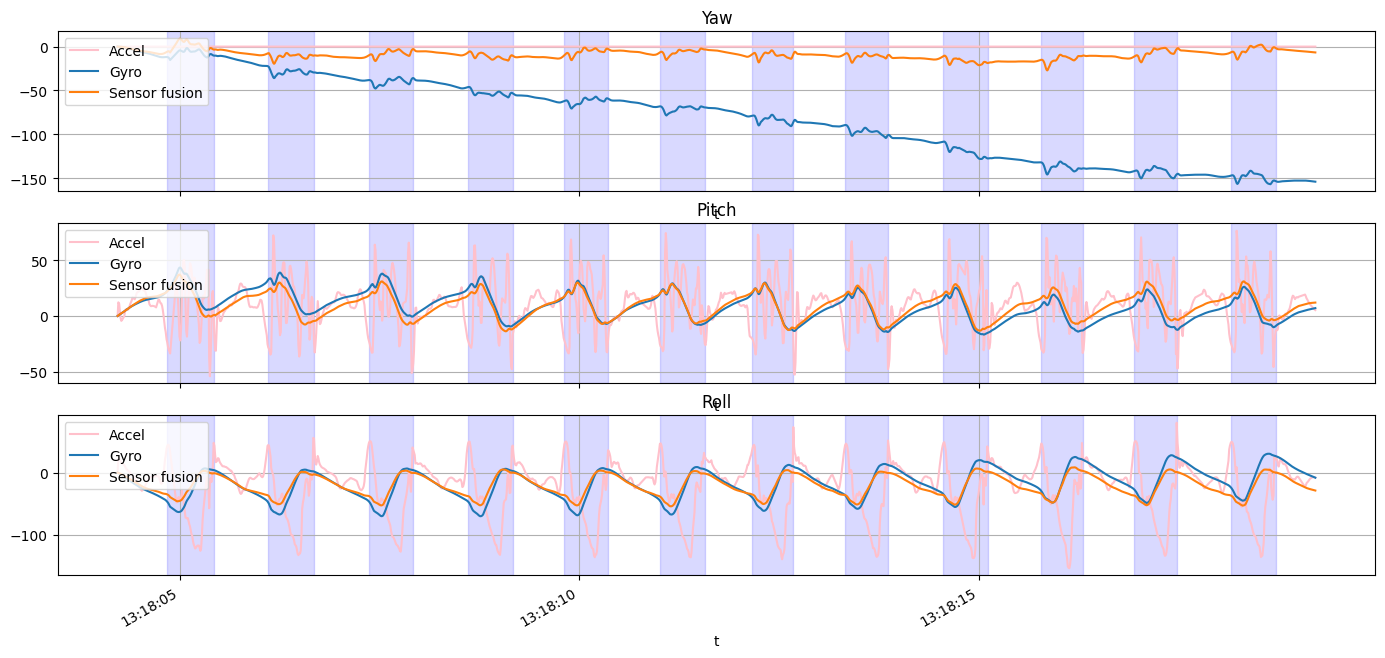

In [93]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

angles['accel.yaw'].plot(ax=ax1, label='Accel', color='pink')
angles['gyro.yaw'].plot(ax=ax1, label='Gyro')
angles['fusion.yaw'].plot(ax=ax1, label='Sensor fusion')
ax1.legend(loc='upper left')
ax1.grid()
ax1.set_title('Yaw')
ax1.xaxis.set_ticklabels([])

angles['accel.pitch'].plot(ax=ax2, label='Accel', color='pink')
angles['gyro.pitch'].plot(ax=ax2, label='Gyro')
angles['fusion.pitch'].plot(ax=ax2, label='Sensor fusion')
ax2.legend(loc='upper left')
ax2.grid()
ax2.set_title('Pitch')
ax2.xaxis.set_ticklabels([])

angles['accel.roll'].plot(ax=ax3, label='Accel', color='pink')
angles['gyro.roll'].plot(ax=ax3, label='Gyro')
angles['fusion.roll'].plot(ax=ax3, label='Sensor fusion')
ax3.legend(loc='upper left')
ax3.grid()
ax3.set_title('Roll')

for ax in [ax1, ax2, ax3]:
    for (i, step) in steps.iterrows():
        ax.axvspan(
            step['start'],
            step['finished'],
            color='blue',
            alpha=0.15
        )

fig.set_figwidth(17)
fig.set_figheight(8)

### Review quaternion values from gyro

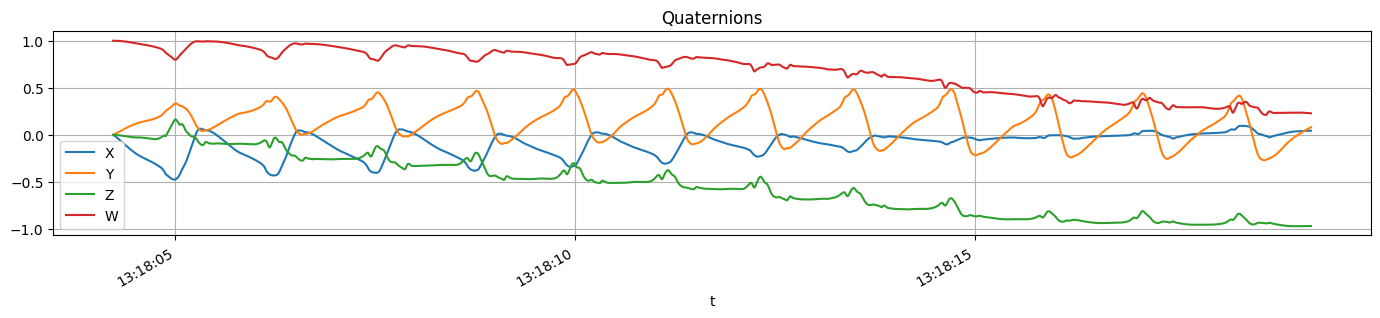

In [94]:
fig, ax1 = plt.subplots(1, 1)

angles['gyro.x'].plot(ax=ax1, label='X')
angles['gyro.y'].plot(ax=ax1, label='Y')
angles['gyro.z'].plot(ax=ax1, label='Z')
angles['gyro.w'].plot(ax=ax1, label='W')
ax1.grid()
ax1.set_title('Quaternions')
ax1.legend()

fig.set_figwidth(17)
fig.set_figheight(3)

### Packets per second

<Axes: xlabel='t'>

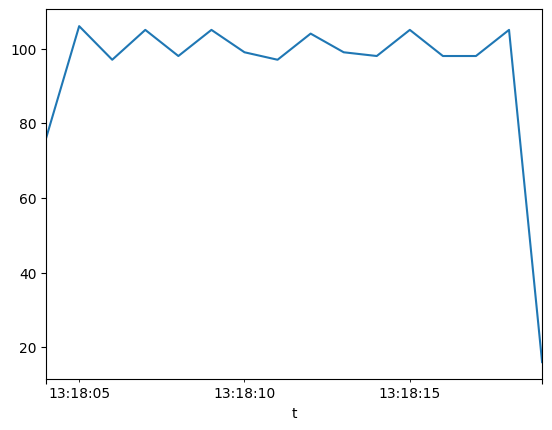

In [95]:
packets = data.resample('1s').count()
packets.drop(columns=['gyro.x','gyro.y'], inplace=True)
packets.rename(columns={'time': 'packets/s'}, inplace=True)
packets['packets/s'].plot()

### Analyze the detected steps

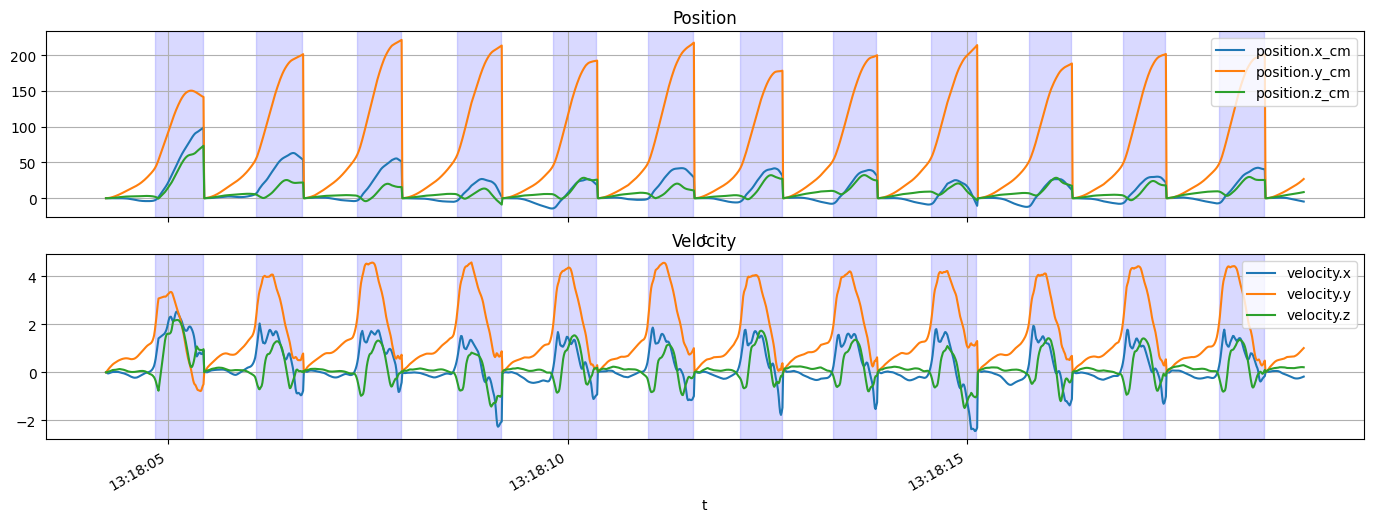

In [96]:
fig, (ax1, ax2) = plt.subplots(2, 1)

algo['position.x_cm'] = algo['position.x'] * 100
algo['position.y_cm'] = algo['position.y'] * 100
algo['position.z_cm'] = algo['position.z'] * 100

algo['position.x_cm'].plot(ax=ax1)
algo['position.y_cm'].plot(ax=ax1)
algo['position.z_cm'].plot(ax=ax1)
ax1.legend(loc='upper right')
ax1.grid()
ax1.set_title('Position')
ax1.xaxis.set_ticklabels([])

algo['velocity.x'].plot(ax=ax2)
algo['velocity.y'].plot(ax=ax2)
algo['velocity.z'].plot(ax=ax2)
ax2.legend(loc='upper right')
ax2.grid()
ax2.set_title('Velocity')

for ax in [ax1, ax2]:
    for (i, step) in steps.iterrows():
        ax.axvspan(
            step['start'],
            step['finished'],
            color='blue',
            alpha=0.15
        )

fig.set_figwidth(17)
fig.set_figheight(6)